In [1]:
using Pkg 
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using ReactiveMP,RxInfer,GraphPPL
using Random, Distributions, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets 
using KernelFunctions, LoopVectorization
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix, kernelmatrix! 
import ReactiveMP: approximate_meancov, SphericalRadialCubature, log2π

In [3]:
function generate_data(rng, A, B, Q, P)
    x_prev = [ 10.0, -10.0 ]

    x = Vector{Vector{Float64}}(undef, n)
    y = Vector{Vector{Float64}}(undef, n)

    for i in 1:n
        x[i] = rand(rng, MvNormal(A * x_prev, Q))
        y[i] = rand(rng, MvNormal(B * x[i], P))
        x_prev = x[i]
    end
    
    return x, y
end
     

generate_data (generic function with 1 method)

In [265]:

# Seed for reproducibility
seed = 1234

rng = MersenneTwister(1234)
d = 2 #number of dimension
θ = π / 60
A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ] # transition matrix 
B = diageye(d) 
Q = 0.1*diageye(d) #covariance matrix for process noise 
P = 1 .* diageye(d) # covariance matrix for likelihood

# Number of observations
n = 150;
transition_func = (x) -> A * x 

#generate data 
true_state, data = generate_data(rng, A, B, Q, P);

## Prepare for GP

In [266]:
# Get ghcubature points and weights 

Unit_Normal = MvNormal(zeros(d),diageye(d))
points = ReactiveMP.getpoints(ghcubature(121), mean(Unit_Normal), cov(Unit_Normal)) #get ghcubature points 
weights = ReactiveMP.getweights(ghcubature(121), mean(Unit_Normal), cov(Unit_Normal)) #get ghcubature weights 

list_gh_points = [] # store ghcubature points in a list 
list_gh_weights = [] # store ghcubature weights in a list 
for (index, (weight, point)) in enumerate(zip(weights, points))
    append!(list_gh_points, point)
    append!(list_gh_weights,weight)
end
list_gh_points = [list_gh_points[i:i+1] for i=1:d:length(list_gh_points)];
list_gh_points = convert(Vector{Vector{Float64}},list_gh_points); # get a list of ghcubature points 
list_gh_weights = convert(Vector{Float64},list_gh_weights); # get a list of ghcubature weights

pdfUnitNormal_ghpoints = map((x) -> pdf(Unit_Normal,x), list_gh_points); #estimate the pdf of Unit_Normal with the gh_points for later use 

In [267]:
# Create inducing points and kernel for GP 
# manual_select_Xu = [[-2.5,-3.5], [-1.3, -5.3], [-4.3, 0], [-0.1, 5], [1., 2.], [10., 5.], [14,2.5], [7.5, 7.], [-2, -6.]];
Nu_x1 = 10; #number of points on the first axis  
Nu_x2 = 10; #number of points on the second axis
M = Nu_x1 * Nu_x2; #total number of inducing points 
Xu_grid =  vec(collect(Iterators.product(range(-5,5;length=Nu_x1), range(-5,5;length=Nu_x2))))
Xu = [[i...] for i in Xu_grid] # a set of inducing points

Xu = true_state[1:70] #temporary
M = length(Xu); #temporary
# Xu = manual_select_Xu
# M = length(Xu)

kernel_gp   =   20*with_lengthscale(SEKernel(),[9, 10]) +  20 * with_lengthscale(Matern52Kernel(),[12, 10]) + 20. * with_lengthscale(LinearKernel(),[11, 10]) #+ with_lengthscale(PeriodicKernel(),3.14) + 2.1 *with_lengthscale(SEKernel(),1.5) + 17*with_lengthscale(Matern52Kernel(),[9, 10]) + 
Kuu = kernelmatrix(kernel_gp,Xu,Xu) + 1e-7*I;
Kuu_inverse = cholinv(Kuu);
C = diageye(2)  #coregionalization matrix 

# calculate some importance functions in advance for later use
Ψ0_weightfunction_value = [kernelmatrix(kernel_gp,[list_gh_points[i]],[list_gh_points[i]]) * list_gh_weights[i] / pdf(Unit_Normal,list_gh_points[i]) for i=1:length(list_gh_weights)]
Ψ1_weightfunction_value = [kernelmatrix(kernel_gp,[list_gh_points[i]],Xu) * list_gh_weights[i] / pdf(Unit_Normal,list_gh_points[i]) for i=1:length(list_gh_weights)];
Ψ2_weightfunction_value = [kernelmatrix(kernel_gp,Xu,[list_gh_points[i]]) * kernelmatrix(kernel_gp,[list_gh_points[i]],Xu) * list_gh_weights[i] / pdf(Unit_Normal,list_gh_points[i]) for i=1:length(list_gh_weights)]

# Prepare for backward message toward x 
Afunc = (x) -> kron(C,kernelmatrix(kernel_gp,[x],[x])[] - getindex(kernelmatrix(kernel_gp,[x],Xu) * Kuu_inverse * kernelmatrix(kernel_gp,Xu,[x]),1))
Bfunc = (x) -> kron(C,kernelmatrix(kernel_gp, [x], Xu) * Kuu_inverse)

A_val = Afunc.(list_gh_points);
B_val = Bfunc.(list_gh_points);

In [268]:
## Function find Ψ0, Ψ1, Ψ2 
# function find_Ψ(dist, Ψ_weightfunc_val , points)
#     g = (x) -> pdf(dist,x)
#     @inbounds pdf_result = g.(points) .* Ψ_weightfunc_val |> sum
#     return pdf_result
# end
function find_Ψ0!(cache,Ψ, func, Ψ_weightfunc_val, points)
    cv = getcache(cache,(:Ψ0_temp,size(Ψ)))
    @inbounds pdf_result = func.(points)
    for (index, Ψw) in enumerate(Ψ_weightfunc_val)
        broadcast!(*, cv, Ψw, pdf_result[index])  # cv = Ψw * pdf_result 
        index == 1 ? broadcast!(.+,Ψ,cv,0) : broadcast!(+,Ψ,Ψ,cv)
    end
    return Ψ
end
function find_Ψ1!(cache,Ψ, func, Ψ_weightfunc_val, points)
    cv = getcache(cache,(:Ψ1_temp,size(Ψ)))
    @inbounds pdf_result = func.(points)
    for (index, Ψw) in enumerate(Ψ_weightfunc_val)
        broadcast!(*, cv, Ψw, pdf_result[index])  # cv = Ψw * pdf_result 
        index == 1 ? broadcast!(.+,Ψ,cv,0) : broadcast!(+,Ψ,Ψ,cv)
    end
    return Ψ
end
function find_Ψ2!(cache,Ψ, func, Ψ_weightfunc_val, points)
    cv = getcache(cache,(:Ψ2_temp, size(Ψ)))
    @inbounds pdf_result = func.(points)
    for (index, Ψw) in enumerate(Ψ_weightfunc_val)
        broadcast!(*, cv, Ψw, pdf_result[index])  # cv = Ψw * pdf_result 
        index == 1 ? broadcast!(.+,Ψ,cv,0) : broadcast!(+,Ψ,Ψ,cv)
    end
    return Ψ
end

function approx_mean_cov_message(weighted_values, points_generator, ndims)
    cs = zeros(length(points_generator))
    norm = 0.
    μ_approx = zeros(ndims)
    for (index, point) in enumerate(points_generator)
        cv = weighted_values[index]
        # mean = mean + point * weight * g(point)
        broadcast!(*, point, point, cv)  # point *= cv
        broadcast!(+, μ_approx, μ_approx, point) # mean += point
        norm += cv

        @inbounds cs[index] = cv
    end
    broadcast!(/, μ_approx, μ_approx, norm)
    cov = zeros(ndims, ndims)
    foreach(enumerate(zip(points_generator, cs))) do (index, (point, c))
        broadcast!(-, point, point, μ_approx)                # point -= mean
        mul!(cov, point, reshape(point, (1, ndims)), c, 1.0) # cov = cov + c * (point)⋅(point)' where c = weight * g(point)
    end

    broadcast!(/, cov, cov, norm)
    return μ_approx, cov 

end



approx_mean_cov_message (generic function with 1 method)

## Use GPTransition node

In [269]:
struct GPCache
    cache_matrices::Dict{Tuple{Symbol, Tuple{Int, Int}}, Matrix{Float64}}
    cache_vectors::Dict{Tuple{Symbol, Int}, Vector{Float64}}
end

GPCache() = GPCache(Dict{Tuple{Symbol, Tuple{Int, Int}}, Matrix{Float64}}(), Dict{Tuple{Symbol, Int}, Vector{Float64}}())

function getcache(cache::GPCache, label::Tuple{Symbol, Tuple{Int, Int}})
    return get!(() -> Matrix{Float64}(undef, label[2]), cache.cache_matrices, label)
end

function getcache(cache::GPCache, label::Tuple{Symbol, Int})
    return get!(() -> Vector{Float64}(undef, label[2]), cache.cache_vectors, label)
end

function mul_A_B!(cache::GPCache, A, B, sizeA1, sizeB2)
    #multiply 2 matrices with different sizes 
    # sizeA1 = size(A,1) ;    sizeB2 = size(B,2)
    AB = getcache(cache, (:ABdiff, (sizeA1,sizeB2)))
    return mul!(AB, A, B)
end

function mul_A_B!(cache::GPCache, A, B, size1)
    #multiply 2 matrices with the same size
    #A, B are square matrices with a same size
    #size1 is size(A,1) = size(B,1)
    AB = getcache(cache, (:AB, (size1, size1)))
    return mul!(AB, A, B)
end

function mul_A_B_A!(cache::GPCache, A, B, size1)
    #A, B are square matrices with a same size
    #size1 is size(A,1) = size(B,1)
    AB = getcache(cache, (:AB, (size1, size1)))
    ABA = getcache(cache, (:ABA, (size1, size1)))
    mul!(AB, A, B)

    return mul!(ABA, AB, A)
end
function mul_A_B_At!(cache::GPCache, A, B, sizeA1,sizeB1)
    # A: matrix with size (sizeA1,sizeB1)
    # B: matrix with size (sizeB1,sizeB1)
    
    AB = getcache(cache, (:AB, (sizeA1, sizeB1)))
    ABAt = getcache(cache, (:ABA, (sizeA1, sizeA1)))
    mul!(AB, A, B)

    return mul!(ABAt, AB, A')
end

function mul_A_v!(cache::GPCache, A, v, sizeA1)
    Av = getcache(cache, (:Av, sizeA1))
    return mul!(Av, A, v)
end

gpcache = GPCache()

GPCache(Dict{Tuple{Symbol, Tuple{Int64, Int64}}, Matrix{Float64}}(), Dict{Tuple{Symbol, Int64}, Vector{Float64}}())

In [270]:
struct GPTransitionMeta{I,T}
    M           :: I    # number of inducing points 
    D           :: I    # number of dimension
    Kuu_inverse :: T  
    C           :: T    # co-regionalization matrix 
    GPCache     :: GPCache
end
getNumberInducingPoints(meta::GPTransitionMeta) = meta.M 
getNumberDimensions(meta::GPTransitionMeta) = meta.D
getinverseKuu(meta::GPTransitionMeta) = meta.Kuu_inverse
getCoregionalizationMatrix(meta::GPTransitionMeta) = meta.C
getGPCache(meta::GPTransitionMeta) = meta.GPCache

getGPCache (generic function with 1 method)

In [271]:
function jdotavx(a, b)
    s = zero(eltype(a))
    @turbo for i ∈ eachindex(a, b)
        s += a[i] * b[i]
    end
    s
end

jdotavx (generic function with 1 method)

In [272]:
struct GPTransition end 

@node GPTransition Stochastic [ out, in, u , γ] ## out: x_t , in: x_{t-1},  u: inducing points , γ: process noise 

@rule GPTransition(:out, Marginalisation) (q_in::MultivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::GammaShapeRate, meta::GPTransitionMeta,) = begin
    M = getNumberInducingPoints(meta) #number of inducing points
    D = getNumberDimensions(meta) #dimension 
    Kuu_inverse = getinverseKuu(meta)
    cache = getGPCache(meta)

    μ_u = mean(q_u)
    Q = 1/mean(q_γ) 
    @inbounds μ_u = [view(μ_u,i:i+M-1) for i=1:M:M*D] 
    Ψ1 = getcache(cache,(:Ψ1,(1,M)))
    Ψ1 = find_Ψ1!(cache,Ψ1, (x) -> pdf(q_in,x), Ψ1_weightfunction_value , list_gh_points)
    μ_y = getcache(cache, (:μ_y, D))
    μ_u_transformed = getcache(cache, (:μ_u_transformed, M))
    for (i,μ_u_entry) in enumerate(μ_u)
        mul!(μ_u_transformed,Kuu_inverse,μ_u_entry)
        @inbounds μ_y[i] = jdotavx(Ψ1,μ_u_transformed)
    end
    return MvNormalMeanCovariance(μ_y, Q*diageye(D))
end

@rule GPTransition(:out, Marginalisation) (q_in::MultivariateGaussianDistributionsFamily, q_u::MultivariateGaussianDistributionsFamily, q_γ::PointMass, meta::GPTransitionMeta) = begin 
    M = getNumberInducingPoints(meta) #number of inducing points
    D = getNumberDimensions(meta) #dimension 
    Kuu_inverse = getinverseKuu(meta)
    cache = getGPCache(meta)

    μ_u = mean(q_u)
    Q = 1/mean(q_γ) 
    @inbounds μ_u = [view(μ_u,i:i+M-1) for i=1:M:M*D] 
    Ψ1 = getcache(cache,(:Ψ1,(1,M)))
    Ψ1 = find_Ψ1!(cache,Ψ1, (x) -> pdf(q_in,x), Ψ1_weightfunction_value , list_gh_points)
    μ_y = getcache(cache, (:μ_y, D))
    μ_u_transformed = getcache(cache, (:μ_u_transformed, M))
    for (i,μ_u_entry) in enumerate(μ_u)
        mul!(μ_u_transformed,Kuu_inverse,μ_u_entry)
        @inbounds μ_y[i] = jdotavx(Ψ1,μ_u_transformed)
    end
    return MvNormalMeanCovariance(μ_y, Q*diageye(D))
end


@rule GPTransition(:in, Marginalisation) (q_out::MultivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::GammaShapeRate, meta::GPTransitionMeta) = begin
    μ_y, Σ_y = mean_cov(q_out)
    μ_u, Σ_u = mean_cov(q_u)
    γ_bar = mean(q_γ) 
    E_logγ = mean(log,q_γ)
    D = getNumberDimensions(meta)
    M = getNumberInducingPoints(meta)
    cache = getGPCache(meta)
    
    backwardmess = (Ax, Bx) -> exp(-0.5*d * log2π + 0.5*d*E_logγ - 0.5 * γ_bar * (tr(Ax) + tr(Σ_y) + tr(mul_A_B_At!(cache,Bx,Σ_u,D,D*M)) + (μ_y' - mul_A_v!(cache,Bx,μ_u,D)') * (μ_y - mul_A_v!(cache,Bx,μ_u,D))))
    @inbounds backwardmess_val = list_gh_weights .* backwardmess.(A_val,B_val) ./ pdfUnitNormal_ghpoints .+ 1e-12
    m, Σ = approx_mean_cov_message(backwardmess_val,points,d)

    return MvNormalMeanCovariance(m, Σ)
end

@rule GPTransition(:u, Marginalisation) (q_out::MultivariateNormalDistributionsFamily, q_in::MultivariateNormalDistributionsFamily, q_γ::GammaShapeRate,meta::GPTransitionMeta) = begin
    γ_bar = mean(q_γ)
    μ_y = mean(q_out)
    D = getNumberDimensions(meta)
    M = getNumberInducingPoints(meta)
    Kuu_inverse = getinverseKuu(meta)
    C = getCoregionalizationMatrix(meta)
    cache = getGPCache(meta)
    
    #Remember to change Unit_Normal
    Ψ1 = getcache(cache,(:Ψ1,(1,M)))
    Ψ2 = getcache(cache,(:Ψ2, (M,M)))
    Ψ1 = find_Ψ1!(cache,Ψ1,(x) -> pdf(q_in,x), Ψ1_weightfunction_value , list_gh_points)
    Ψ2 = find_Ψ2!(cache,Ψ2,(x) -> pdf(q_in,x), Ψ2_weightfunction_value , list_gh_points)

    #we'll use NormalWeightedMeanPrecision
    ξ_u = Float64[]
    Ψ1_transformed = mul_A_B!(cache,Kuu_inverse,Ψ1',M,1) |> vec #Ψ1_transformed = Kuu_inverse * Ψ1'
    for mu_y in μ_y
        ξ = γ_bar * mu_y .* Ψ1_transformed
        append!(ξ_u, ξ)
    end

    Ψ2_transformed = mul_A_B_A!(cache, Kuu_inverse, Ψ2,M) # Ψ2_transformed = Kuu_inverse * Ψ2 * Kuu_inverse
    W_u = getcache(cache, (:W_u, (D*M,D*M)))
    kron!(W_u,C,γ_bar .* Ψ2_transformed)
    return MvNormalWeightedMeanPrecision(ξ_u, W_u)
end

@rule GPTransition(:u, Marginalisation) (q_out::MultivariateNormalDistributionsFamily, q_in::MultivariateNormalDistributionsFamily, q_γ::PointMass,meta::GPTransitionMeta) = begin
    γ_bar = mean(q_γ)
    μ_y = mean(q_out)
    D = getNumberDimensions(meta)
    M = getNumberInducingPoints(meta)
    Kuu_inverse = getinverseKuu(meta)
    C = getCoregionalizationMatrix(meta)
    cache = getGPCache(meta)
    
    #Remember to change Unit_Normal
    Ψ1 = getcache(cache,(:Ψ1,(1,M)))
    Ψ2 = getcache(cache,(:Ψ2, (M,M)))
    Ψ1 = find_Ψ1!(cache,Ψ1,(x) -> pdf(q_in,x), Ψ1_weightfunction_value , list_gh_points)
    Ψ2 = find_Ψ2!(cache,Ψ2,(x) -> pdf(q_in,x), Ψ2_weightfunction_value , list_gh_points)

    #we'll use NormalWeightedMeanPrecision
    ξ_u = Float64[]
    Ψ1_transformed = mul_A_B!(cache,Kuu_inverse,Ψ1',M,1) |> vec #Ψ1_transformed = Kuu_inverse * Ψ1'
    for mu_y in μ_y
        ξ = γ_bar * mu_y .* Ψ1_transformed
        append!(ξ_u, ξ)
    end

    Ψ2_transformed = mul_A_B_A!(cache, Kuu_inverse, Ψ2,M) # Ψ2_transformed = Kuu_inverse * Ψ2 * Kuu_inverse
    W_u = getcache(cache, (:W_u, (D*M,D*M)))
    kron!(W_u,C,γ_bar .* Ψ2_transformed)
    return MvNormalWeightedMeanPrecision(ξ_u, W_u)
end

@rule GPTransition(:γ, Marginalisation) (q_out::MultivariateGaussianDistributionsFamily, q_in::MultivariateGaussianDistributionsFamily,q_u::MultivariateNormalDistributionsFamily,meta::GPTransitionMeta,) = begin
    μ_y, var_y = mean_var(q_out)
    μ_u, Σ_u = mean_cov(q_u)
    D = getNumberDimensions(meta)  #dimension
    M = getNumberInducingPoints(meta) #number of inducing points
    cache = getGPCache(meta)
    μ_u = [view(μ_u,i:i+M-1) for i=1:M:M*D]  
    Σ_u = [view(Σ_u,i:i+M-1,i:i+M-1) for i=1:M:M*D]
    Kuu_inverse = getinverseKuu(meta)

    #Remember to change Unit_Normal
    Ψ0 = getcache(cache,(:Ψ0,(1,1)))
    Ψ1 = getcache(cache,(:Ψ1,(1,M)))
    Ψ2 = getcache(cache,(:Ψ2, (M,M)))
    Ψ0 = find_Ψ0!(cache,Ψ0,(x) -> pdf(q_in,x), Ψ0_weightfunction_value , list_gh_points)
    Ψ1 = find_Ψ1!(cache,Ψ1,(x) -> pdf(q_in,x), Ψ1_weightfunction_value , list_gh_points)
    Ψ2 = find_Ψ2!(cache,Ψ2,(x) -> pdf(q_in,x), Ψ2_weightfunction_value , list_gh_points)
    I1 = I2 = 0.

    trace_A = mul_A_B!(cache,Kuu_inverse,Ψ2,M) |> tr #trA =tr(Kuu_inverse * Ψ2)

    B_mat = mul_A_B!(cache,Ψ1,Kuu_inverse,1,M) #B = Ψ1 * Kuu_inverse
    Ψ2_transformed = mul_A_B_A!(cache, Kuu_inverse, Ψ2,M) # E = Kuu_inverse * Ψ2 * Kuu_inverse

    for (μ_y_entry, μ_u_entry, var_y_entry,Σ_u_entry) in zip(μ_y, μ_u, var_y,Σ_u)
        @inbounds I1 += getindex(Ψ0,1) - trace_A
        I2 += μ_y_entry^2 + var_y_entry -2*μ_y_entry * getindex(B_mat * μ_u_entry,1) + tr(mul_A_B!(cache,(Σ_u_entry .+ μ_u_entry * μ_u_entry'), Ψ2_transformed,M))
    end
    return GammaShapeRate(1+D/2, 0.5*(I1 + I2))
end

@rule GPTransition(:in, Marginalisation) (q_out::MultivariateGaussianDistributionsFamily, q_u::MultivariateGaussianDistributionsFamily, q_γ::PointMass, meta::GPTransitionMeta) = begin 
    μ_y, Σ_y = mean_cov(q_out)
    μ_u, Σ_u = mean_cov(q_u)
    γ_bar = mean(q_γ) 
    # E_logγ = mean(log,q_γ)
    D = getNumberDimensions(meta)
    M = getNumberInducingPoints(meta)
    cache = getGPCache(meta)
    
    backwardmess = (Ax, Bx) -> exp(-0.5*d * log2π + 0.5*d*log(γ_bar) - 0.5 * γ_bar * (tr(Ax) + tr(Σ_y) + tr(mul_A_B_At!(cache,Bx,Σ_u,D,D*M)) + (μ_y' - mul_A_v!(cache,Bx,μ_u,D)') * (μ_y - mul_A_v!(cache,Bx,μ_u,D))))
    @inbounds backwardmess_val = list_gh_weights .* backwardmess.(A_val,B_val) ./ pdfUnitNormal_ghpoints .+ 1e-12
    m, Σ = approx_mean_cov_message(backwardmess_val,points,d)

    return MvNormalMeanCovariance(m, Σ)
end


@average_energy GPTransition (q_out::MultivariateNormalDistributionsFamily, q_in::MultivariateGaussianDistributionsFamily, q_u::MultivariateNormalDistributionsFamily, q_γ::GammaShapeRate, meta::GPTransitionMeta,) = begin
    μ_y, var_y = mean_var(q_out)
    μ_u, Σ_u = mean_cov(q_u)
    γ_bar = mean(q_γ) 
    E_logγ = mean(log,q_γ)
    D = getNumberDimensions(meta)  #dimension
    M = getNumberInducingPoints(meta) #number of inducing points
    cache = getGPCache(meta)
    μ_u = [view(μ_u,i:i+M-1) for i=1:M:M*D]  
    Σ_u = [view(Σ_u,i:i+M-1,i:i+M-1) for i=1:M:M*D]
    Kuu_inverse = getinverseKuu(meta)

    #Remember to change Unit_Normal
    Ψ0 = getcache(cache,(:Ψ0,(1,1)))
    Ψ1 = getcache(cache,(:Ψ1,(1,M)))
    Ψ2 = getcache(cache,(:Ψ2, (M,M)))
    Ψ0 = find_Ψ0!(cache,Ψ0,(x) -> pdf(q_in,x), Ψ0_weightfunction_value , list_gh_points)
    Ψ1 = find_Ψ1!(cache,Ψ1,(x) -> pdf(q_in,x), Ψ1_weightfunction_value , list_gh_points)
    Ψ2 = find_Ψ2!(cache,Ψ2,(x) -> pdf(q_in,x), Ψ2_weightfunction_value , list_gh_points)
    I1 = I2 = 0.

    trace_A = mul_A_B!(cache,Kuu_inverse,Ψ2,M) |> tr #trA =tr(Kuu_inverse * Ψ2)

    B_mat = mul_A_B!(cache,Ψ1,Kuu_inverse,1,M) #B = Ψ1 * Kuu_inverse
    Ψ2_transformed = mul_A_B_A!(cache, Kuu_inverse, Ψ2,M) # E = Kuu_inverse * Ψ2 * Kuu_inverse

    for (μ_y_entry, μ_u_entry, var_y_entry,Σ_u_entry) in zip(μ_y, μ_u, var_y,Σ_u)
        @inbounds I1 += getindex(Ψ0,1) - trace_A
        I2 += μ_y_entry^2 + var_y_entry -2*μ_y_entry * getindex(B_mat * μ_u_entry,1) + tr(mul_A_B!(cache,(Σ_u_entry .+ μ_u_entry * μ_u_entry'), Ψ2_transformed,M))
    end
    return 0.5*γ_bar*(I1 + I2) + 0.5*D*(log2π - E_logγ)
end

@average_energy GPTransition (q_out::MultivariateNormalDistributionsFamily, q_in::MultivariateGaussianDistributionsFamily, q_u::MultivariateNormalDistributionsFamily, q_γ::PointMass, meta::GPTransitionMeta,) = begin
    μ_y, var_y = mean_var(q_out)
    μ_u, Σ_u = mean_cov(q_u)
    γ_bar = mean(q_γ) 
    E_logγ = log(γ_bar)
    D = getNumberDimensions(meta)  #dimension
    M = getNumberInducingPoints(meta) #number of inducing points
    cache = getGPCache(meta)
    μ_u = [view(μ_u,i:i+M-1) for i=1:M:M*D]  
    Σ_u = [view(Σ_u,i:i+M-1,i:i+M-1) for i=1:M:M*D]
    Kuu_inverse = getinverseKuu(meta)

    #Remember to change Unit_Normal
    Ψ0 = getcache(cache,(:Ψ0,(1,1)))
    Ψ1 = getcache(cache,(:Ψ1,(1,M)))
    Ψ2 = getcache(cache,(:Ψ2, (M,M)))
    Ψ0 = find_Ψ0!(cache,Ψ0,(x) -> pdf(q_in,x), Ψ0_weightfunction_value , list_gh_points)
    Ψ1 = find_Ψ1!(cache,Ψ1,(x) -> pdf(q_in,x), Ψ1_weightfunction_value , list_gh_points)
    Ψ2 = find_Ψ2!(cache,Ψ2,(x) -> pdf(q_in,x), Ψ2_weightfunction_value , list_gh_points)
    I1 = I2 = 0.

    trace_A = mul_A_B!(cache,Kuu_inverse,Ψ2,M) |> tr #trA =tr(Kuu_inverse * Ψ2)

    B_mat = mul_A_B!(cache,Ψ1,Kuu_inverse,1,M) #B = Ψ1 * Kuu_inverse
    Ψ2_transformed = mul_A_B_A!(cache, Kuu_inverse, Ψ2,M) # E = Kuu_inverse * Ψ2 * Kuu_inverse

    for (μ_y_entry, μ_u_entry, var_y_entry,Σ_u_entry) in zip(μ_y, μ_u, var_y,Σ_u)
        @inbounds I1 += getindex(Ψ0,1) - trace_A
        I2 += μ_y_entry^2 + var_y_entry -2*μ_y_entry * getindex(B_mat * μ_u_entry,1) + tr(mul_A_B!(cache,(Σ_u_entry .+ μ_u_entry * μ_u_entry'), Ψ2_transformed,M))
    end
    return 0.5*γ_bar*(I1 + I2) + 0.5*D*(log2π - E_logγ)
end

In [273]:
@model function gpssm(n,x0,Kuu_inverse_big)
    y = datavar(Vector{Float64},n)
    x = randomvar(n)

    u ~ MvNormalWeightedMeanPrecision(zeros(size(Kuu_inverse_big,1)), Kuu_inverse_big)
    # w ~ GammaShapeRate(1.,0.1)
    x_prior ~ MvNormalMeanCovariance(mean(x0), cov(x0))
    x_prev = x_prior
    for i=1:n
        x[i] ~ GPTransition(x_prev,u,10. * θ^2) where { q = MeanField() }  #mean-field assumption
        y[i] ~ MvNormalMeanCovariance(B * x[i], P)
        x_prev = x[i]
    end
end

In [274]:
@meta function gpssm_meta(M,D,Kuu_inverse,C,gpcache)
    GPTransition(x,u) -> GPTransitionMeta(M,D,Kuu_inverse,C,gpcache)
end


gpssm_meta (generic function with 1 method)

In [275]:
@rule MvNormalWeightedMeanPrecision(:out, Marginalisation) (q_ξ::PointMass, q_Λ::PointMass, ) = begin 
    return MvNormalWeightedMeanPrecision(mean(q_ξ),mean(q_Λ))
end

In [276]:
x0 = MvNormalMeanCovariance(zeros(2), 50.0 * diageye(2));

In [277]:
niter = 6;

infer_result = inference(
    model = gpssm(n,x0,kron(C,Kuu_inverse)),
    iterations = niter,
    data = (y = data,),
    initmarginals = (u = MvNormalWeightedMeanPrecision(zeros(size(kron(C,Kuu),1)), kron(C,Kuu_inverse)), x = MvNormalMeanCovariance(zeros(2), 50.0 * diageye(2)),),
    meta = gpssm_meta(M,d,Kuu_inverse,C,gpcache),
    returnvars = (x = KeepLast(), u = KeepLast(),),
    free_energy = true,
    showprogress = true
) 

Progress:  33%|█████████████▋                           |  ETA: 0:03:59

Progress:  50%|████████████████████▌                    |  ETA: 0:02:58

Progress:  67%|███████████████████████████▍             |  ETA: 0:01:59

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:59

Progress: 100%|█████████████████████████████████████████| Time: 0:05:56


Inference results:
  Posteriors       | available for (u, x)
  Free Energy:     | Real[908.503, 907.713, 888.369, 888.348, 888.484, 888.311]


In [278]:
qu = infer_result.posteriors[:u]
qx = infer_result.posteriors[:x]
# qw = infer_result.posteriors[:w]
;

In [279]:
# mean(qw)

In [280]:
# w_axis = collect(0:0.01:1.5)
# plot(w_axis, pdf.(qw,w_axis))
# vline!([100])

In [281]:
true_val = transition_func.(Xu);

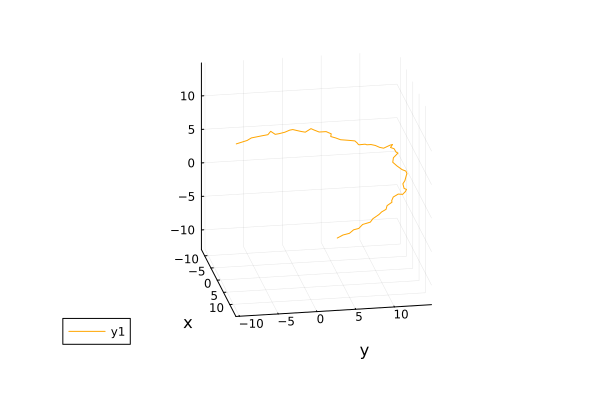

In [282]:
plot(getindex.(Xu, 1),getindex.(Xu, 2), getindex.(true_val, 1); camera = (80,20), color = :orange)
xlabel!("x")
ylabel!("y")

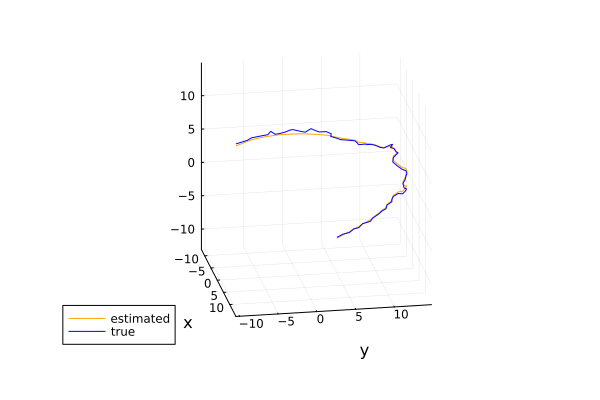

In [283]:
μ_u_concat = mean(qu);
μ_u = reshape(μ_u_concat,M,2)';
μ_u = [μ_u[:,i] for i=1:M]
;
plot(getindex.(Xu, 1),getindex.(Xu, 2), getindex.(μ_u, 1), label="estimated"; camera = (80,20), color = :orange)
plot!(getindex.(Xu, 1),getindex.(Xu, 2), getindex.(true_val, 1), label = "true"; camera = (80,20), color = :blue)
xlabel!("x")
ylabel!("y")

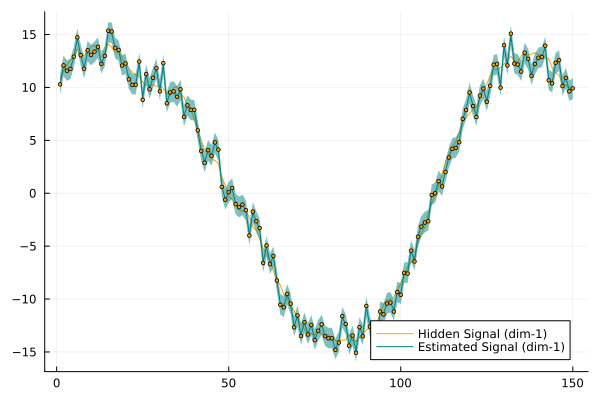

In [286]:
px = plot()

px = plot!(px, getindex.(true_state, 1), label = "Hidden Signal (dim-1)", color = :orange)
# px = plot!(px, getindex.(true_state, 2), label = "Hidden Signal (dim-2)", color = :green)

px = plot!(px, getindex.(mean.(qx), 1), ribbon = getindex.(var.(qx), 1) .|> sqrt, fillalpha = 0.5, label = "Estimated Signal (dim-1)", color = :teal)
# px = plot!(px, getindex.(mean.(qx), 2), ribbon = getindex.(var.(qx), 2) .|> sqrt, fillalpha = 0.5, label = "Estimated Signal (dim-1)", color = :violet)
px = scatter!(px, getindex.(data, 1), label = false, markersize = 2, color = :orange)
plot(px)

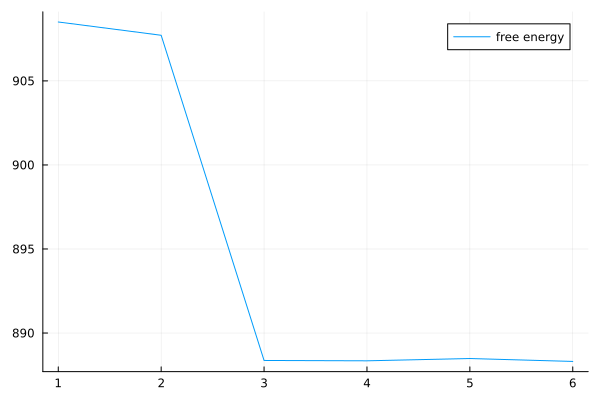

In [287]:
plot(infer_result.free_energy, label="free energy")

## Use Ground truth model

In [27]:
@model function rotate_ssm(n, x0, A, B, Q, P)
    
    x = randomvar(n)
    y = datavar(Vector{Float64}, n)
    
    x_prior ~ MvNormalMeanCovariance(mean(x0), cov(x0))
    x_prev = x_prior
    
    for i in 1:n
        x[i] ~ MvNormalMeanCovariance(A * x_prev, Q)
        y[i] ~ MvNormalMeanCovariance(B * x[i], P)
        x_prev = x[i]
    end

end

In [28]:
true_result = inference(
    model = rotate_ssm(n, x0, A, B, Q, P), 
    data = (y = data,),
    free_energy = true
)


Inference results:
  Posteriors       | available for (x_prior, x)
  Free Energy:     | Real[785.227]


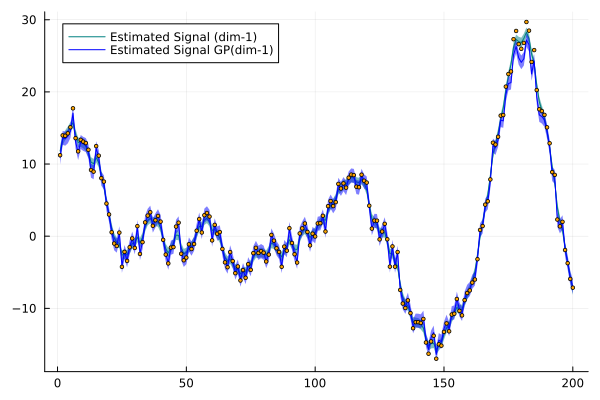

In [51]:
xmarginals  = true_result.posteriors[:x]
px = plot()

# px = plot!(px, getindex.(true_state, 1), label = "Hidden Signal (dim-1)", color = :orange)
# px = plot!(px, getindex.(true_state, 2), label = "Hidden Signal (dim-2)", color = :green)

px = plot!(px, getindex.(mean.(xmarginals), 1), ribbon = getindex.(var.(xmarginals), 1) .|> sqrt, fillalpha = 0.5, label = "Estimated Signal (dim-1)", color = :teal)
# px = plot!(px, getindex.(mean.(xmarginals), 2), ribbon = getindex.(var.(xmarginals), 2) .|> sqrt, fillalpha = 0.5, label = "Estimated Signal (dim-1)", color = :violet)
px = plot!(px, getindex.(mean.(qx), 1), ribbon = getindex.(var.(qx), 1) .|> sqrt, fillalpha = 0.5, label = "Estimated Signal GP(dim-1)", color = :blue)
px = scatter!(px, getindex.(data, 1), label = false, markersize = 2, color = :orange)

plot(px)


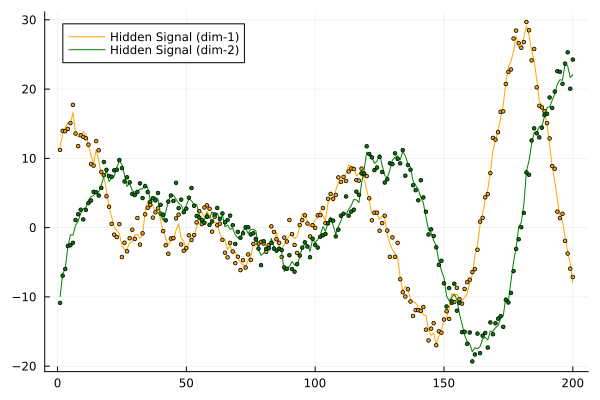

In [30]:

px = plot()

px = plot!(px, getindex.(true_state, 1), label = "Hidden Signal (dim-1)", color = :orange)
px = scatter!(px, getindex.(data, 1), label = false, markersize = 2, color = :orange)
px = plot!(px, getindex.(true_state, 2), label = "Hidden Signal (dim-2)", color = :green)
px = scatter!(px, getindex.(data, 2), label = false, markersize = 2, color = :green)

plot(px)

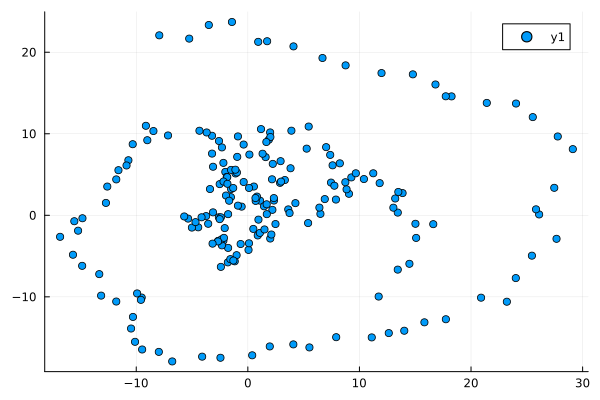

In [1021]:
scatter(getindex.(true_state, 1),getindex.(true_state, 2))

In [69]:
manual_select_Xu = [[-2.5,-3.5], [-1.3, -5.3], [-4.3, 0], [-0.1, 5], [1., 2.], [10., 5.], [14,2.5], [7.5, 7.], [-2, -6.]];

100-element Vector{Vector{Float64}}:
 [11.72348323093797, -9.965093666774871]
 [13.433953356799666, -6.662214695025911]
 [14.47940302752061, -5.9481679032719255]
 [15.082367302413372, -2.773515689579622]
 [15.0190904154249, -1.04066331416596]
 [16.61608054877271, -1.0869083912496973]
 [13.435259160640983, 0.3329066170389081]
 [13.041178664848662, 0.9331868884552557]
 [13.20745099487252, 2.061986400670866]
 [13.866194467362085, 2.724062332997059]
 ⋮
 [-1.5675298758082643, -5.377150844544686]
 [-1.2968717899969546, -5.549394007630293]
 [0.061769267072596556, -4.24554756356453]
 [2.0088775150323768, -2.848426341230529]
 [2.1079983493484056, -2.3560151350950806]
 [0.8886655932758354, -2.46841319084582]
 [0.10178434617105525, -3.4345673757810875]
 [0.49196644347854596, -1.6698993835359306]
 [1.0790944772403706, -2.1585636783198257]

## store scraps

In [ ]:
# Nu = 150; #number of inducing points 
# Xu_grid =  vec(collect(Iterators.product(range(0,2;length=3), range(0,3;length=3))))
# Xu = [[i...] for i in Xu_grid]
# kxu = (x) -> kernelmatrix(kernel, [x], Xu) * pdf(q_in,x) / pdf(Unit_Normal,x)
# kxxu = (x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu) * pdf(q_in,x) / pdf(Unit_Normal,x)
# k0 = (x) -> kernelmatrix(kernel, [x], [x]) * pdf(q_in,x) / pdf(Unit_Normal,x)
# kxu = (x) -> kernelmatrix(kernel, [x], Xu) * pdf(q_in,x) / pdf(Unit_Normal,x)
# kxxu = (x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu) * pdf(q_in,x) / pdf(Unit_Normal,x)
# μ_y[i] = getindex(Ψ1 * Kuu_inverse * μ_u[i],1)
# function approx_kernel_expectation(g::Function, weights, points)
    #     gbar = g(zeros(d)) - g(zeros(d))
    #     foreach(zip(weights, points)) do (weight, point)
    #         axpy!(weight, g(point), gbar) # gbar = gbar + weight * g(point)
    #     end
    #     return gbar 
    # end

    # A = (x) -> kron(C,kernelmatrix(kernel,[x],[x])[] - getindex(kernelmatrix(kernel,[x],Xu) * Kuu_inverse * kernelmatrix(kernel,Xu,[x]),1))
    # B = (x) -> kron(C,kernelmatrix(kernel, [x], Xu) * Kuu_inverse)
        # return ContinuousMultivariateLogPdf(DomainSets.FullSpace() ^ D,log_backwardmess)

# function for computing backward message toward x edge of the GP node
# function approx_mean_cov(weighted_value, dist, points_list ,points_generator)
#     g = (x) -> pdf(dist,x)
#     weighted_gv = g.(points_list) .* weighted_value   
#     m = mean(dist)
#     ndims = length(m)

#     cs = similar(m, eltype(m), length(points_generator))
#     norm = 0.
#     μ_approx = zeros(ndims)

#     for (index, point) in enumerate(points_generator)
#         cv = weighted_gv[index]
#         # mean = mean + point * weight * g(point)
#         broadcast!(*, point, point, cv)  # point *= cv
#         broadcast!(+, μ_approx, μ_approx, point) # mean += point
#         norm += cv

#         @inbounds cs[index] = cv
#     end
#     broadcast!(/, μ_approx, μ_approx, norm)
#     cov = zeros(ndims, ndims)
#     foreach(enumerate(zip(points_generator, cs))) do (index, (point, c))
#         broadcast!(-, point, point, μ_approx)                # point -= mean
#         mul!(cov, point, reshape(point, (1, ndims)), c, 1.0) # cov = cov + c * (point)⋅(point)' where c = weight * g(point)
#     end

#     broadcast!(/, cov, cov, norm)
#     return μ_approx, cov 
# end μ_u_transformed = getcache(cache,(:μ_u_transformed, D))

In [51]:
using SparseArrays

In [55]:
Kuu_inverse

400×400 Matrix{Float64}:
  0.84901      -0.5831        0.191639     …  -6.96537e-13  -9.6557e-13
 -0.5831        1.28785      -0.736265        -3.91243e-13  -6.96537e-13
  0.191639     -0.736265      1.34323         -7.76263e-13  -1.46578e-12
 -0.0620527     0.243106     -0.755264        -8.40841e-13  -1.82708e-12
  0.0169189    -0.076825      0.248707        -8.48243e-13  -1.91934e-12
 -0.00559988    0.0218426    -0.0786992    …  -5.00083e-13  -8.17707e-13
  0.00157931   -0.00708192    0.0224245        3.64784e-13   2.64561e-12
 -0.00052631    0.00206337   -0.00727032       2.19523e-12   1.00775e-11
  0.000160198  -0.000685233   0.00212734       5.49865e-12   2.33232e-11
 -5.12631e-5    0.000209286  -0.000704703      1.20726e-11   4.29991e-11
  ⋮                                        ⋱                
  2.33232e-11   5.49865e-12   2.73034e-11     -0.000685233   0.000160198
  1.00775e-11   2.19523e-12   1.51387e-11      0.00206337   -0.00052631
  2.64561e-12   3.64784e-13   7.11238e-1